In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import BDay

import eikon as ek
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

In [3]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst.
    The last 'chunk' will be the remaining elements of lst if it is less than 3000.
    
    lst (pandas.core.indexes.datetimes.DatetimeIndex): Index of all elements that wants to be 'chunked'.
    It can be a Numpy array too if needed.
    
    n (int): size odf the 1st 'chunks' requiered to be yielded."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def ek_get_large_timeseries(rics = ['EUR='], fields = 'CLOSE', corax = "adjusted",
                            start = dt.datetime(1999,1,1),
                            end = dt.datetime.today()):
    
    """ The ' ek_get_large_timeseries ' function allows users to request data via the
    ' ek.get_timeseries ' (with the same parameters)  without the 3000 datapoint limit.
    
    For argument list, see the arguments for ' ek.get_timeseries '.
    
    Nessesitates eikon set_app_key and the function 'chunks(lst, n)' to be predefined
    and the following libraries: 'pandas as pd' and 'datetime as dt'."""
    
    df = [] # Empty list to populate
    NoI = len(rics)
    maxno = int(3000/NoI)
    for _df in chunks(pd.date_range(start=start,end=end), maxno): # The max. number of datapoints retrievable in any one request is 3000

        data = ek.get_timeseries(rics = rics, fields = fields, corax =corax,
                                 start_date = _df[0].strftime("%Y-%m-%d"), 
                                 end_date = _df[-1].strftime("%Y-%m-%d"))
        df.append(data)

    return pd.concat(df,axis=0)

In [7]:

instruments = ['AAPL.O']
fields = ['CLOSE']
index = ['Date']
start_date = '2000-01-01'
end_date = '2021-12-31'
data = ek.get_timeseries(instruments, fields, start_date, end_date)
data.head()

AAPL.O,CLOSE
Date,
2010-02-03,7.11535
2010-02-04,6.858922
2010-02-05,6.980707
2010-02-08,6.93285
2010-02-09,7.006779


In [8]:
data = data.astype('float64')
symbol = ['CLOSE']
SMA1 = 20 # Calculates the values for the shorter SMA.
SMA2 = 100 #Calculates the values for the longer SMA.
data['SMA1'] = data[symbol].rolling(SMA1).mean()
data['SMA2'] = data[symbol].rolling(SMA2).mean()
data.tail()

AAPL.O,CLOSE,SMA1,SMA2
Date,,,
2021-12-27,180.33,171.4630,153.3444
2021-12-28,179.29,172.4155,153.6667
2021-12-29,179.38,173.1195,153.9991
2021-12-30,178.20,173.7910,154.3202
2021-12-31,177.57,174.4815,154.6399


<AxesSubplot:xlabel='Date'>

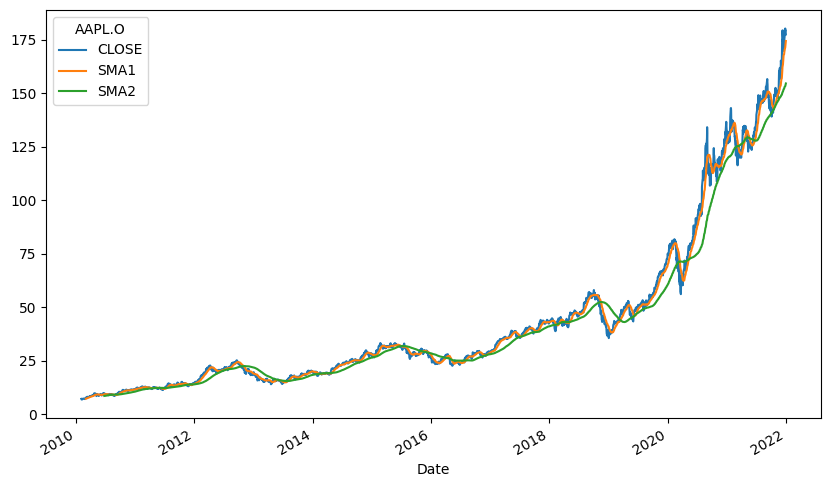

In [11]:
data.plot(figsize= (10,6))

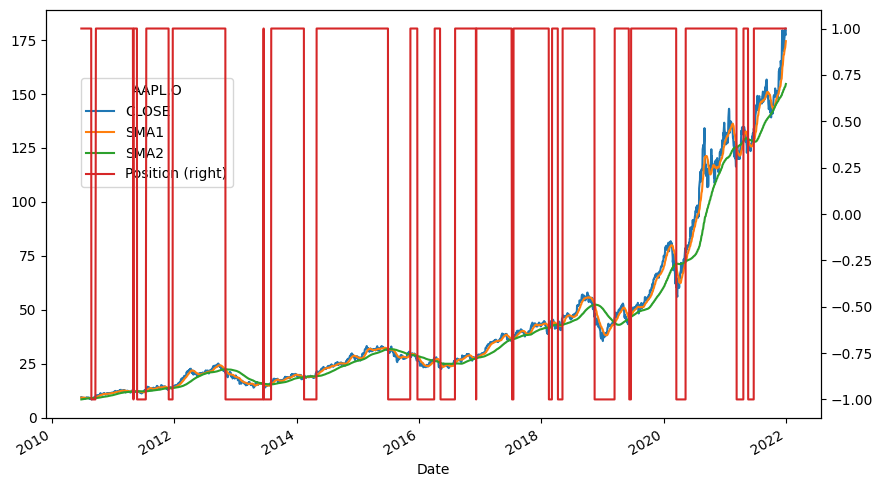

In [12]:
#dropping any missing values 
data.dropna(inplace = True)
# setting the parameters for the buy or sell indicatior
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
# shows the indicators of when to buy or sell 
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

In [13]:
#Vectorized back testing
#shows the return of following the trading strategy
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
data['Strategy'] = data['Position'].shift(1) * data['Returns']
data.round(4).tail()

AAPL.O,CLOSE,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2021-12-27,180.33,171.4630,153.3444,1,0.0227,0.0227
2021-12-28,179.29,172.4155,153.6667,1,-0.0058,-0.0058
2021-12-29,179.38,173.1195,153.9991,1,0.0005,0.0005
2021-12-30,178.20,173.7910,154.3202,1,-0.0066,-0.0066
2021-12-31,177.57,174.4815,154.6399,1,-0.0035,-0.0035


In [14]:
data.dropna(inplace = True)
#exponential value at absolute performance  
np.exp(data[['Returns', 'Strategy']].sum())

AAPL.O
Returns     18.642538
Strategy     3.568468
dtype: float64

In [15]:
#annualized volatility
data[['Returns', 'Strategy']].std() * (252 ** 0.5)

AAPL.O
Returns     0.279548
Strategy    0.279919
dtype: float64

In [17]:
#optimizing 
from itertools import product
sma1 = range(1, 21, 2) # Specifies the parameter values for SMA1
sma2 = range(20, 101, 10) # Specifies the parameter values for SMA2.

results = pd.DataFrame()

data = ek_get_large_timeseries("JD.L", fields="CLOSE", start = dt.datetime(2010, 1, 1), end=dt.datetime(2021, 12, 31))
print(data.head())

# Combines all values for SMA1 with those for SMA2.
for SMA1, SMA2 in product(sma1, sma2): 
    data.dropna(inplace=True)
    data['Returns'] = np.log(data["CLOSE"] / data["CLOSE"].shift(1))
    data['SMA1'] = data["CLOSE"].rolling(SMA1).mean()
    data['SMA2'] = data["CLOSE"].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    
    # Records the vectorized backtesting results in a DataFrame object.
    results = results.append(pd.DataFrame(
        {'SMA1': SMA1, 'SMA2': SMA2,
        'MARKET': perf['Returns'],
        'STRATEGY': perf['Strategy'],
        'OUT': perf['Strategy'] - perf['Returns']},
        index=[0]), ignore_index=True)

JD.L        CLOSE
Date             
2010-01-04   5.12
2010-01-05   5.18
2010-01-06    5.5
2010-01-07   6.15
2010-01-08  6.565


In [18]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
52,11,90,1.0,1.0,0.0
80,17,100,1.0,1.0,0.0
73,17,30,1.0,1.0,0.0
74,17,40,1.0,1.0,0.0
75,17,50,1.0,1.0,0.0
76,17,60,1.0,1.0,0.0
77,17,70,1.0,1.0,0.0


Because we can see that the strategy is 1.0 through out the table, 
this strategy does not have a way to beat the market.